In [1]:
# standard regular-use python packages
import numpy as np
import pandas as pd
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

# standard astropy packages
from astropy.cosmology import WMAP9 as cosmo
import astropy.units as u

# packages needed for plotting
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

# packages needed to use Leja et al. (2022) normalizing flows results
import torch
import os
import torch_light
import sample_nf_probability_density
from pathlib import Path
from astropy.convolution import Gaussian1DKernel, convolve
from scipy.stats import norm as norm_density

# standard imports for my work
from bpt_utils import *
from read_transients_data import *
from correct_redshift_evolution import *
from generate_bkg_galaxies import *
from helper_functions import *

# set up plotting
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams.update(
    {
        'text.usetex': False,
        'font.family': 'stixgeneral',
        'mathtext.fontset': 'stix',
    }
)
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['image.origin'] = 'lower'
sns.set_context('talk') 
sns.set(font_scale=1.6)
sns.set_palette('colorblind')
sns.set_style('ticks')
plt.rcParams["font.family"] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Tahoma', 'Verdana', 'Lucida Grande', 'DejaVu Sans']



In [2]:
# Grid parameters for galaxy density function in logMass - logSFR - redshift space
nlogm, nsfr, dz = 40, 40, 0.001
mmin, mmax = 5, 12
sfrmin, sfrmax = -5, 3

# Generating the galaxy density function grid in logMass - logSFR - redshift space
redshifts, bkg_grid_below_mcomp = generate_bkg_grid_below_mcomp()
kernel = Gaussian1DKernel(stddev=2) 
prob_smooth = np.zeros(np.shape(bkg_grid_below_mcomp))
for i in range(nlogm):
    for j in range(nsfr):
        prob_smooth[:][i][j] = convolve(bkg_grid_below_mcomp[:][i][j],kernel,boundary='extend',preserve_nan=True)
bkg_grid_below_mcomp = prob_smooth



100%|██████████████████████████████████████████████████████████████| 50/50 [14:21<00:00, 17.24s/it]


In [3]:
# Generate 1000 realizations of background galaxies with 10000 galaxies each 
# in the three redshift bins

f_r = 3e10*1400e-8/(6215e-8**2)
F_r = 10**((23.5)/-2.5)*3631*1e-23*f_r #erg/s/cm2
Nbkg = 1000
Nsamp = 10000

bkg_redshift_z1, logmstar_bkgs_z1, logsfr_bkgs_z1 = [], [], []
logmstar_bkgs_z1_wo_opt_cut, logsfr_bkgs_z1_wo_opt_cut = [], []
for j in tqdm(range(Nbkg)):
    ml_random = np.random.normal(0, 0.2)
    z_random = np.random.uniform(0, 0.2)
    logmstar_bkg, logsfr_bkg = generate_bkg_z(z_random, Nsamp, redshifts, bkg_grid_below_mcomp)
    mmin_ = ml_random+np.log10(F_r*(4*np.pi*(cosmo.luminosity_distance(z_random).to(u.cm).value**2))/4e33)
    mask = np.array(logmstar_bkg)>mmin_ # applying the optical observation bias
    bkg_redshift_z1.append(z_random)
    logmstar_bkgs_z1.append(np.array(logmstar_bkg)[mask])
    logsfr_bkgs_z1.append(np.array(logsfr_bkg)[mask])
    logmstar_bkgs_z1_wo_opt_cut.append(np.array(logmstar_bkg))
    logsfr_bkgs_z1_wo_opt_cut.append(np.array(logsfr_bkg))

bkg_redshift_z2, logmstar_bkgs_z2, logsfr_bkgs_z2 = [], [], []
logmstar_bkgs_z2_wo_opt_cut, logsfr_bkgs_z2_wo_opt_cut = [], []
for j in tqdm(range(Nbkg)):
    ml_random = np.random.normal(0, 0.26)
    z_random = np.random.uniform(0.2, 0.4)
    logmstar_bkg, logsfr_bkg = generate_bkg_z(z_random, Nsamp, redshifts, bkg_grid_below_mcomp)
    mmin_ = ml_random+np.log10(F_r*(4*np.pi*(cosmo.luminosity_distance(z_random).to(u.cm).value**2))/4e33)
    mask = logmstar_bkg>mmin_ # applying the optical observation bias
    bkg_redshift_z2.append(z_random)
    logmstar_bkgs_z2.append(np.array(logmstar_bkg)[mask])
    logsfr_bkgs_z2.append(np.array(logsfr_bkg)[mask])
    logmstar_bkgs_z2_wo_opt_cut.append(np.array(logmstar_bkg))
    logsfr_bkgs_z2_wo_opt_cut.append(np.array(logsfr_bkg))

bkg_redshift_z3, logmstar_bkgs_z3, logsfr_bkgs_z3 = [], [], []
logmstar_bkgs_z3_wo_opt_cut, logsfr_bkgs_z3_wo_opt_cut = [], []
for j in tqdm(range(Nbkg)):
    ml_random = np.random.normal(0, 0.3)
    z_random = np.random.uniform(0.4, 0.7)
    logmstar_bkg, logsfr_bkg = generate_bkg_z(z_random, Nsamp, redshifts, bkg_grid_below_mcomp)
    mmin_ = ml_random+np.log10(F_r*(4*np.pi*(cosmo.luminosity_distance(z_random).to(u.cm).value**2))/4e33)
    mask = logmstar_bkg>mmin_ # applying the optical observation bias
    bkg_redshift_z3.append(z_random)
    logmstar_bkgs_z3.append(np.array(logmstar_bkg)[mask])
    logsfr_bkgs_z3.append(np.array(logsfr_bkg)[mask])
    logmstar_bkgs_z3_wo_opt_cut.append(np.array(logmstar_bkg))
    logsfr_bkgs_z3_wo_opt_cut.append(np.array(logsfr_bkg))


100%|██████████████████████████████████████████████████████████| 1000/1000 [09:28<00:00,  1.76it/s]


In [4]:
# Computing histograms of mass and SFR-weighted background galaxy distributions in each
# of the three redshift bins

out_bkg_m_z1, out_bkg_m_z2, out_bkg_m_z3 = [], [], []
out_bkg_s_z1, out_bkg_s_z2, out_bkg_s_z3 = [], [], []

out_bkg_m_z1_wo_opt_cut, out_bkg_m_z2_wo_opt_cut, out_bkg_m_z3_wo_opt_cut = [], [], []
out_bkg_s_z1_wo_opt_cut, out_bkg_s_z2_wo_opt_cut, out_bkg_s_z3_wo_opt_cut = [], [], []

bins_logM = np.linspace(5, 12, 100)


for j in tqdm(range(Nbkg)):
    logmsamples = np.random.choice(logmstar_bkgs_z1[j], size=Nsamp, replace=True, 
                                   p=10**np.array(logsfr_bkgs_z1[j])/sum(10**np.array(logsfr_bkgs_z1[j])))
    out = plt.hist(logmsamples, bins=bins_logM, alpha=0, histtype="step", color="blue", lw=1, density=True, cumulative=True)
    out_bkg_s_z1.append(out[0])

    logmsamples = np.random.choice(logmstar_bkgs_z1[j], size=Nsamp, replace=True, 
                                   p=10**np.array(logmstar_bkgs_z1[j])/sum(10**np.array(logmstar_bkgs_z1[j])))
    out = plt.hist(logmsamples, bins=bins_logM, alpha=0, histtype="step", color="blue", lw=1, density=True, cumulative=True)
    out_bkg_m_z1.append(out[0])


    logmsamples = np.random.choice(logmstar_bkgs_z2[j], size=Nsamp, replace=True, 
                                   p=10**np.array(logsfr_bkgs_z2[j])/sum(10**np.array(logsfr_bkgs_z2[j])))
    out = plt.hist(logmsamples, bins=bins_logM, alpha=0, histtype="step", color="blue", lw=1, density=True, cumulative=True)
    out_bkg_s_z2.append(out[0])

    logmsamples = np.random.choice(logmstar_bkgs_z2[j], size=Nsamp, replace=True, 
                                   p=10**np.array(logmstar_bkgs_z2[j])/sum(10**np.array(logmstar_bkgs_z2[j])))
    out = plt.hist(logmsamples, bins=bins_logM, alpha=0, histtype="step", color="blue", lw=1, density=True, cumulative=True)
    out_bkg_m_z2.append(out[0])


    logmsamples = np.random.choice(logmstar_bkgs_z2[j], size=Nsamp, replace=True, 
                                   p=10**np.array(logsfr_bkgs_z2[j])/sum(10**np.array(logsfr_bkgs_z2[j])))
    out = plt.hist(logmsamples, bins=bins_logM, alpha=0, histtype="step", color="blue", lw=1, density=True, cumulative=True)
    out_bkg_s_z3.append(out[0])

    logmsamples = np.random.choice(logmstar_bkgs_z3[j], size=Nsamp, replace=True, 
                                   p=10**np.array(logmstar_bkgs_z3[j])/sum(10**np.array(logmstar_bkgs_z3[j])))
    out = plt.hist(logmsamples, bins=bins_logM, alpha=0, histtype="step", color="blue", lw=1, density=True, cumulative=True)
    out_bkg_m_z3.append(out[0])

    
    ###############################################################################################################
    ###############################################################################################################
    ###############################################################################################################


    logmsamples = np.random.choice(logmstar_bkgs_z1_wo_opt_cut[j], size=Nsamp, replace=True, 
                                   p=10**np.array(logsfr_bkgs_z1_wo_opt_cut[j])/sum(10**np.array(logsfr_bkgs_z1_wo_opt_cut[j])))
    out = plt.hist(logmsamples, bins=bins_logM, alpha=0, histtype="step", color="blue", lw=1, density=True, cumulative=True)
    out_bkg_s_z1_wo_opt_cut.append(out[0])

    logmsamples = np.random.choice(logmstar_bkgs_z1_wo_opt_cut[j], size=Nsamp, replace=True, 
                                   p=10**np.array(logmstar_bkgs_z1_wo_opt_cut[j])/sum(10**np.array(logmstar_bkgs_z1_wo_opt_cut[j])))
    out = plt.hist(logmsamples, bins=bins_logM, alpha=0, histtype="step", color="blue", lw=1, density=True, cumulative=True)
    out_bkg_m_z1_wo_opt_cut.append(out[0])


    logmsamples = np.random.choice(logmstar_bkgs_z2_wo_opt_cut[j], size=Nsamp, replace=True, 
                                   p=10**np.array(logsfr_bkgs_z2_wo_opt_cut[j])/sum(10**np.array(logsfr_bkgs_z2_wo_opt_cut[j])))
    out = plt.hist(logmsamples, bins=bins_logM, alpha=0, histtype="step", color="blue", lw=1, density=True, cumulative=True)
    out_bkg_s_z2_wo_opt_cut.append(out[0])

    logmsamples = np.random.choice(logmstar_bkgs_z2_wo_opt_cut[j], size=Nsamp, replace=True, 
                                   p=10**np.array(logmstar_bkgs_z2_wo_opt_cut[j])/sum(10**np.array(logmstar_bkgs_z2_wo_opt_cut[j])))
    out = plt.hist(logmsamples, bins=bins_logM, alpha=0, histtype="step", color="blue", lw=1, density=True, cumulative=True)
    out_bkg_m_z2_wo_opt_cut.append(out[0])


    logmsamples = np.random.choice(logmstar_bkgs_z2_wo_opt_cut[j], size=Nsamp, replace=True, 
                                   p=10**np.array(logsfr_bkgs_z2_wo_opt_cut[j])/sum(10**np.array(logsfr_bkgs_z2_wo_opt_cut[j])))
    out = plt.hist(logmsamples, bins=bins_logM, alpha=0, histtype="step", color="blue", lw=1, density=True, cumulative=True)
    out_bkg_s_z3_wo_opt_cut.append(out[0])

    logmsamples = np.random.choice(logmstar_bkgs_z3_wo_opt_cut[j], size=Nsamp, replace=True, 
                                   p=10**np.array(logmstar_bkgs_z3_wo_opt_cut[j])/sum(10**np.array(logmstar_bkgs_z3_wo_opt_cut[j])))
    out = plt.hist(logmsamples, bins=bins_logM, alpha=0, histtype="step", color="blue", lw=1, density=True, cumulative=True)
    out_bkg_m_z3_wo_opt_cut.append(out[0])

plt.close()

ms1 = bins_logM; ms2 = bins_logM; ms3 = bins_logM


100%|██████████████████████████████████████████████████████████| 1000/1000 [01:39<00:00, 10.03it/s]


In [7]:
# Reading in DSA, Gordon et al. and Bhardwaj et al. FRBs

dsa_nr_frbs = read_dsa_data()
chime_frbs = read_chime_data()
askap_r_frbs = read_askap_r_frbs()
askap_nr_frbs = read_askap_nr_frbs()

dsa_nr_frbs_z1 = dsa_nr_frbs[dsa_nr_frbs.redshift<=0.2].reset_index()
askap_r_frbs_z1 = askap_r_frbs[askap_r_frbs.z<=0.2].reset_index()
askap_nr_frbs_z1 = askap_nr_frbs[askap_nr_frbs.z<=0.2].reset_index()
N_z1 = len(dsa_nr_frbs_z1)+len(askap_r_frbs_z1)+len(askap_nr_frbs_z1)+len(chime_frbs)

dsa_nr_frbs_z2 = dsa_nr_frbs[np.logical_and(dsa_nr_frbs.redshift>0.2, dsa_nr_frbs.redshift<=0.4)].reset_index()
askap_r_frbs_z2 = askap_r_frbs[np.logical_and(askap_r_frbs.z>0.2, askap_r_frbs.z<=0.4)].reset_index()
askap_nr_frbs_z2 = askap_nr_frbs[np.logical_and(askap_nr_frbs.z>0.2, askap_nr_frbs.z<=0.4)].reset_index()
N_z2 = len(dsa_nr_frbs_z2)+len(askap_r_frbs_z2)+len(askap_nr_frbs_z2)

dsa_nr_frbs_z3 = dsa_nr_frbs[np.logical_and(dsa_nr_frbs.redshift>0.4, dsa_nr_frbs.redshift<=0.7)].reset_index()
askap_r_frbs_z3 = askap_r_frbs[np.logical_and(askap_r_frbs.z>0.4, askap_r_frbs.z<=0.7)].reset_index()
askap_nr_frbs_z3 = askap_nr_frbs[np.logical_and(askap_nr_frbs.z>0.4, askap_nr_frbs.z<=0.7)].reset_index()
N_z3 = len(dsa_nr_frbs_z3)+len(askap_r_frbs_z3)+len(askap_nr_frbs_z3)



In [8]:
# Computing p-values for similarity between FRBs and mass,SFR-weighted background galaxy distributions
# in z<=0.2 redshift bin

import scipy
from scipy import stats

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16, 4.5))

bins = np.linspace(5, 12, 100)
bins_ = []
for i in tqdm(range(len(bins)-1)):
    bins_.append(bins[i]); bins_.append(bins[i+1])

bins__ = []
for i in tqdm(range(len(bins)-1)):
    bins__.append((bins[i]+bins[i+1])/2)

Nbkg = 1000
pvalues_m_z1 = []
pvalues_s_z1 = []
out_frbs_z1 = []
for k in tqdm(range(Nbkg)):
    mstar_samples_r = []
    mstar_samples_nr = []
    for i in range(len(askap_r_frbs_z1)):
        mstar_samples_r = mstar_samples_r + generate_samples(askap_r_frbs_z1.logMstar[i], 
                                                             np.abs(askap_r_frbs_z1.logMstar_errl[i]),
                                                             askap_r_frbs_z1.logMstar_erru[i],
                                                             1)
    for i in range(len(dsa_nr_frbs_z1)): 
        mstar_samples_nr = mstar_samples_nr + generate_samples(dsa_nr_frbs_z1.logMstar[i], 
                                                               np.abs(dsa_nr_frbs_z1.logMstar_errl[i]), 
                                                               dsa_nr_frbs_z1.logMstar_erru[i],
                                                               1)
    for i in range(len(askap_nr_frbs_z1)):
        mstar_samples_nr = mstar_samples_nr + generate_samples(askap_nr_frbs_z1.logMstar[i], 
                                                               np.abs(askap_nr_frbs_z1.logMstar_errl[i]), 
                                                               askap_nr_frbs_z1.logMstar_erru[i],
                                                               1)

    for i in range(len(chime_frbs)):
        mstar_samples_nr = mstar_samples_nr + generate_samples(chime_frbs.logMstar[i], 
                                                               np.abs(chime_frbs.logMstar_errl[i]), 
                                                               chime_frbs.logMstar_erru[i],
                                                               1)
    
    for l in range(100):
        frb_bootstrap_sample = np.random.choice(mstar_samples_r+mstar_samples_nr, len(mstar_samples_r+mstar_samples_nr))
        frb_cum_hist = ax1.hist(mstar_samples_r+mstar_samples_nr,
                                bins=bins, alpha=0, cumulative=True, density=True,
                                histtype="step", color="blue", lw=1, ls="--")
        out_frbs_z1.append(frb_cum_hist[0])
        def compute_s_cdf(m):
            """
            Compute the cumulative distribution function (CDF) of `m` using interpolation.
            Parameters:
            - m: Value or array for which to compute the CDF
            Returns:
            - CDF value at `m` interpolated from `out_bkg_s_z1[k]`
            """
            f = scipy.interpolate.interp1d(bins__, out_bkg_s_z1[k])
            return f(m)
        def compute_m_cdf(m):
            """
            Compute the cumulative distribution function (CDF) of `m` using interpolation.
            Parameters:
            - m: Value or array for which to compute the CDF
            Returns:
            - CDF value at `m` interpolated from `out_bkg_m_z1[k]`
            """
            f = scipy.interpolate.interp1d(bins__, out_bkg_m_z1[k])
            return f(m)
        pvalues_s_z1.append(stats.ks_1samp(frb_bootstrap_sample, cdf = compute_s_cdf).pvalue)
        pvalues_m_z1.append(stats.ks_1samp(frb_bootstrap_sample, cdf = compute_m_cdf).pvalue)

plt.close()

100%|██████████████████████████████████████████████████████████| 1000/1000 [12:24<00:00,  1.34it/s]


In [9]:
# Computing p-values for similarity between FRBs and mass,SFR-weighted background galaxy distributions
# in 0.2<z<=0.4 redshift bin

bins = np.linspace(5, 12, 100)
bins_ = []
for i in tqdm(range(len(bins)-1)):
    bins_.append(bins[i]); bins_.append(bins[i+1])

Nbkg = 1000
pvalues_m_z2 = []
pvalues_s_z2 = []
out_frbs_z2 = []
for k in tqdm(range(Nbkg)):
    mstar_samples_r = []
    mstar_samples_nr = []
    for i in range(len(askap_r_frbs_z2)):
        mstar_samples_r = mstar_samples_r + generate_samples(askap_r_frbs_z2.logMstar[i], 
                                                             np.abs(askap_r_frbs_z2.logMstar_errl[i]),
                                                             askap_r_frbs_z2.logMstar_erru[i],
                                                             1)
    for i in range(len(dsa_nr_frbs_z2)): 
        mstar_samples_nr = mstar_samples_nr + generate_samples(dsa_nr_frbs_z2.logMstar[i], 
                                                               np.abs(dsa_nr_frbs_z2.logMstar_errl[i]), 
                                                               dsa_nr_frbs_z2.logMstar_erru[i],
                                                               1)
    for i in range(len(askap_nr_frbs_z2)):
        mstar_samples_nr = mstar_samples_nr + generate_samples(askap_nr_frbs_z2.logMstar[i], 
                                                               np.abs(askap_nr_frbs_z2.logMstar_errl[i]), 
                                                               askap_nr_frbs_z2.logMstar_erru[i],
                                                               1)
    
    for l in range(100):
        frb_bootstrap_sample = np.random.choice(mstar_samples_r+mstar_samples_nr, len(mstar_samples_r+mstar_samples_nr))
        frb_cum_hist = ax1.hist(mstar_samples_r+mstar_samples_nr,
                                bins=bins, alpha=0, cumulative=True, density=True,
                                histtype="step", color="blue", lw=1, ls="--")
        out_frbs_z2.append(frb_cum_hist[0])
        def compute_s_cdf(m):
            """
            Compute the cumulative distribution function (CDF) of `m` using interpolation.
            Parameters:
            - m: Value or array for which to compute the CDF
            Returns:
            - CDF value at `m` interpolated from `out_bkg_s_z2[k]`
            """
            f = scipy.interpolate.interp1d(bins__, out_bkg_s_z2[k])
            return f(m)
        def compute_m_cdf(m):
            """
            Compute the cumulative distribution function (CDF) of `m` using interpolation.
            Parameters:
            - m: Value or array for which to compute the CDF
            Returns:
            - CDF value at `m` interpolated from `out_bkg_m_z2[k]`
            """
            f = scipy.interpolate.interp1d(bins__, out_bkg_m_z2[k])
            return f(m)
        pvalues_m_z2.append(stats.ks_1samp(frb_bootstrap_sample, cdf = compute_m_cdf).pvalue)
        pvalues_s_z2.append(stats.ks_1samp(frb_bootstrap_sample, cdf = compute_s_cdf).pvalue)

100%|██████████████████████████████████████████████████████████| 1000/1000 [12:43<00:00,  1.31it/s]


In [10]:
# Computing p-values for similarity between FRBs and mass,SFR-weighted background galaxy distributions
# in 0.4<z<=0.7 redshift bin

bins = np.linspace(5, 12, 100)
bins_ = []
for i in tqdm(range(len(bins)-1)):
    bins_.append(bins[i]); bins_.append(bins[i+1])

pvalues_m_z3 = []
pvalues_s_z3 = []
out_frbs_z3 = []
for k in tqdm(range(Nbkg)):
    mstar_samples_r = []
    mstar_samples_nr = []
    for i in range(len(askap_r_frbs_z3)):
        mstar_samples_r = mstar_samples_r + generate_samples(askap_r_frbs_z3.logMstar[i], 
                                                             np.abs(askap_r_frbs_z3.logMstar_errl[i]),
                                                             askap_r_frbs_z3.logMstar_erru[i],
                                                             1)
    for i in range(len(dsa_nr_frbs_z3)): 
        mstar_samples_nr = mstar_samples_nr + generate_samples(dsa_nr_frbs_z3.logMstar[i], 
                                                               np.abs(dsa_nr_frbs_z3.logMstar_errl[i]), 
                                                               dsa_nr_frbs_z3.logMstar_erru[i],
                                                               1)
    for i in range(len(askap_nr_frbs_z3)):
        mstar_samples_nr = mstar_samples_nr + generate_samples(askap_nr_frbs_z3.logMstar[i], 
                                                               np.abs(askap_nr_frbs_z3.logMstar_errl[i]), 
                                                               askap_nr_frbs_z3.logMstar_erru[i],
                                                               1)
    
    for l in range(100):
        frb_bootstrap_sample = np.random.choice(mstar_samples_r+mstar_samples_nr, len(mstar_samples_r+mstar_samples_nr))
        frb_cum_hist = ax1.hist(mstar_samples_r+mstar_samples_nr,
                                bins=bins, alpha=0, cumulative=True, density=True,
                                histtype="step", color="blue", lw=1, ls="--")
        out_frbs_z3.append(frb_cum_hist[0])
        def compute_s_cdf(m):
            """
            Compute the cumulative distribution function (CDF) of `m` using interpolation.
            Parameters:
            - m: Value or array for which to compute the CDF
            Returns:
            - CDF value at `m` interpolated from `out_bkg_s_z3[k]`
            """
            f = scipy.interpolate.interp1d(bins__, out_bkg_s_z3[k])
            return f(m)
        def compute_m_cdf(m):
            """
            Compute the cumulative distribution function (CDF) of `m` using interpolation.
            Parameters:
            - m: Value or array for which to compute the CDF
            Returns:
            - CDF value at `m` interpolated from `out_bkg_m_z3[k]`
            """
            f = scipy.interpolate.interp1d(bins__, out_bkg_m_z3[k])
            return f(m)
        pvalues_m_z3.append(stats.ks_1samp(frb_bootstrap_sample, cdf = compute_m_cdf).pvalue)
        pvalues_s_z3.append(stats.ks_1samp(frb_bootstrap_sample, cdf = compute_s_cdf).pvalue)

100%|██████████████████████████████████████████████████████████| 1000/1000 [11:58<00:00,  1.39it/s]


100%|██████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 958974.82it/s]


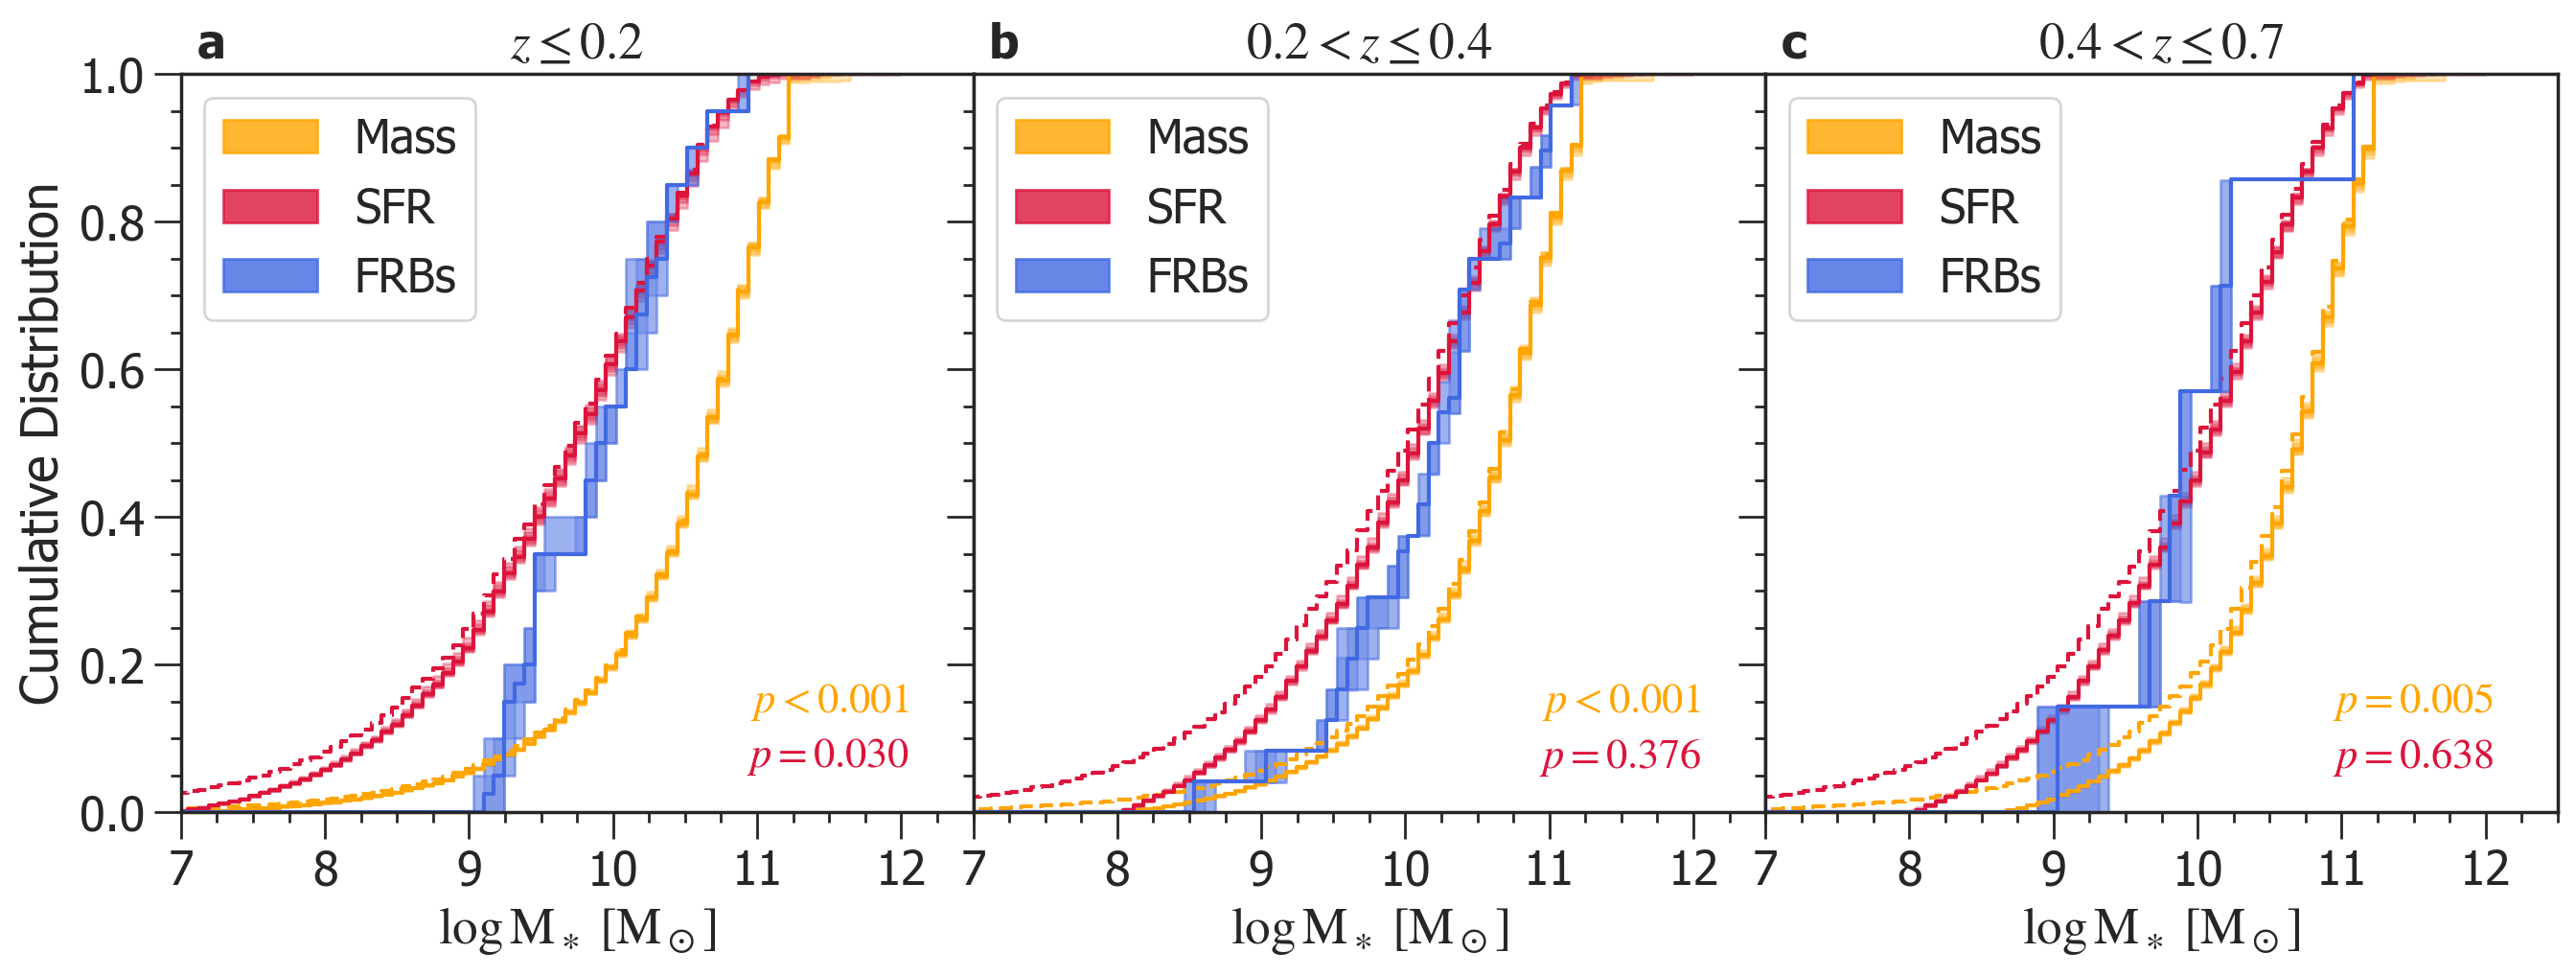

In [11]:
# Plotting the results for comparisons

from matplotlib.ticker import MultipleLocator
bins_logM_ = []
for i in range(len(bins_logM)-1):
    bins_logM_.append(bins_logM[i]), bins_logM_.append(bins_logM[i+1])


fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=True, figsize=(16, 5))
x=1000
ax1.fill_between([], [], [], label="Mass",
                 color="orange", alpha=0.8)
quant16, quant50, quant84 = return_quants(out_bkg_m_z1, 1)
ax1.plot(bins_logM_, quant50, color="orange", ls="solid")
ax1.fill_between(bins_logM_, np.array(quant50)+np.array(quant16)/np.sqrt(x), np.array(quant50)+np.array(quant84)/np.sqrt(x), 
                 color="orange", alpha=0.3)
quant16, quant50, quant84 = return_quants(out_bkg_m_z1, 2)
ax1.fill_between(bins_logM_, np.array(quant50)+np.array(quant16)/np.sqrt(x), np.array(quant50)+np.array(quant84)/np.sqrt(x), 
                 color="orange", alpha=0.3)
quant16, quant50, quant84 = return_quants(out_bkg_m_z1, 3)
ax1.fill_between(bins_logM_, np.array(quant50)+np.array(quant16)/np.sqrt(x), np.array(quant50)+np.array(quant84)/np.sqrt(x), 
                 color="orange", alpha=0.3)
_, quant50, _ = return_quants(out_bkg_m_z1_wo_opt_cut, 1)
ax1.plot(bins_logM_, quant50, color="orange", ls="dashed")

ax1.fill_between([], [], [], label="SFR",
                 color="crimson", alpha=0.8)
quant16, quant50, quant84 = return_quants(out_bkg_s_z1, 1)
ax1.plot(bins_logM_, quant50, color="crimson", ls="solid")
ax1.fill_between(bins_logM_, np.array(quant50)+np.array(quant16)/np.sqrt(x), np.array(quant50)+np.array(quant84)/np.sqrt(x), 
                 color="crimson", alpha=0.3)
quant16, quant50, quant84 = return_quants(out_bkg_s_z1, 2)
ax1.fill_between(bins_logM_, np.array(quant50)+np.array(quant16)/np.sqrt(x), np.array(quant50)+np.array(quant84)/np.sqrt(x), 
                 color="crimson", alpha=0.3)
quant16, quant50, quant84 = return_quants(out_bkg_s_z1, 3)
ax1.fill_between(bins_logM_, np.array(quant50)+np.array(quant16)/np.sqrt(x), np.array(quant50)+np.array(quant84)/np.sqrt(x), 
                 color="crimson", alpha=0.3)
_, quant50, _ = return_quants(out_bkg_s_z1_wo_opt_cut, 1)
ax1.plot(bins_logM_, quant50, color="crimson", ls="dashed")

ax1.set_ylim(0, 1)
ax1.set_xlim(7, 12.5)



ax2.fill_between([], [], [], label="Mass",
                 color="orange", alpha=0.8)
quant16, quant50, quant84 = return_quants(out_bkg_m_z2, 1)
ax2.plot(bins_logM_, quant50, color="orange", ls="solid")
ax2.fill_between(bins_logM_, np.array(quant50)+np.array(quant16)/np.sqrt(x), np.array(quant50)+np.array(quant84)/np.sqrt(x), 
                 color="orange", alpha=0.3)
quant16, quant50, quant84 = return_quants(out_bkg_m_z2, 2)
ax2.fill_between(bins_logM_, np.array(quant50)+np.array(quant16)/np.sqrt(x), np.array(quant50)+np.array(quant84)/np.sqrt(x), 
                 color="orange", alpha=0.3)
quant16, quant50, quant84 = return_quants(out_bkg_m_z2, 3)
ax2.fill_between(bins_logM_, np.array(quant50)+np.array(quant16)/np.sqrt(x), np.array(quant50)+np.array(quant84)/np.sqrt(x), 
                 color="orange", alpha=0.3)
_, quant50, _ = return_quants(out_bkg_m_z2_wo_opt_cut, 1)
ax2.plot(bins_logM_, quant50, color="orange", ls="dashed")

ax2.fill_between([], [], [], label="SFR",
                 color="crimson", alpha=0.8)
quant16, quant50, quant84 = return_quants(out_bkg_s_z2, 1)
ax2.plot(bins_logM_, quant50, color="crimson", ls="solid")
ax2.fill_between(bins_logM_, np.array(quant50)+np.array(quant16)/np.sqrt(x), np.array(quant50)+np.array(quant84)/np.sqrt(x), 
                 color="crimson", alpha=0.3)
quant16, quant50, quant84 = return_quants(out_bkg_s_z2, 2)
ax2.fill_between(bins_logM_, np.array(quant50)+np.array(quant16)/np.sqrt(x), np.array(quant50)+np.array(quant84)/np.sqrt(x), 
                 color="crimson", alpha=0.3)
quant16, quant50, quant84 = return_quants(out_bkg_s_z2, 3)
ax2.fill_between(bins_logM_, np.array(quant50)+np.array(quant16)/np.sqrt(x), np.array(quant50)+np.array(quant84)/np.sqrt(x), 
                 color="crimson", alpha=0.3)
_, quant50, _ = return_quants(out_bkg_s_z2_wo_opt_cut, 1)
ax2.plot(bins_logM_, quant50, color="crimson", ls="dashed")

ax2.set_ylim(0, 1)
ax2.set_xlim(7, 12.5) 


ax3.fill_between([], [], [], label="Mass",
                 color="orange", alpha=0.8)
quant16, quant50, quant84 = return_quants(out_bkg_m_z3, 1)
ax3.plot(bins_logM_, quant50, color="orange", ls="solid")
ax3.fill_between(bins_logM_, np.array(quant50)+np.array(quant16)/np.sqrt(x), np.array(quant50)+np.array(quant84)/np.sqrt(x), 
                 color="orange", alpha=0.3)
quant16, quant50, quant84 = return_quants(out_bkg_m_z3, 2)
ax3.fill_between(bins_logM_, np.array(quant50)+np.array(quant16)/np.sqrt(x), np.array(quant50)+np.array(quant84)/np.sqrt(x), 
                 color="orange", alpha=0.3)
quant16, quant50, quant84 = return_quants(out_bkg_m_z3, 3)
ax3.fill_between(bins_logM_, np.array(quant50)+np.array(quant16)/np.sqrt(x), np.array(quant50)+np.array(quant84)/np.sqrt(x), 
                 color="orange", alpha=0.3)
_, quant50, _ = return_quants(out_bkg_m_z3_wo_opt_cut, 1)
ax3.plot(bins_logM_, quant50, color="orange", ls="dashed")

ax3.fill_between([], [], [], label="SFR",
                 color="crimson", alpha=0.8)
quant16, quant50, quant84 = return_quants(out_bkg_s_z3, 1)
ax3.plot(bins_logM_, quant50, color="crimson", ls="solid")
ax3.fill_between(bins_logM_, np.array(quant50)+np.array(quant16)/np.sqrt(x), np.array(quant50)+np.array(quant84)/np.sqrt(x), 
                 color="crimson", alpha=0.3)
quant16, quant50, quant84 = return_quants(out_bkg_s_z3, 2)
ax3.fill_between(bins_logM_, np.array(quant50)+np.array(quant16)/np.sqrt(x), np.array(quant50)+np.array(quant84)/np.sqrt(x), 
                 color="crimson", alpha=0.3)
quant16, quant50, quant84 = return_quants(out_bkg_s_z3, 3)
ax3.fill_between(bins_logM_, np.array(quant50)+np.array(quant16)/np.sqrt(x), np.array(quant50)+np.array(quant84)/np.sqrt(x), 
                 color="crimson", alpha=0.3)
_, quant50, _ = return_quants(out_bkg_s_z3_wo_opt_cut, 1)
ax3.plot(bins_logM_, quant50, color="crimson", ls="dashed")

ax3.set_ylim(0, 1)
ax3.set_xlim(7, 12.5)


ax1.set_ylabel("Cumulative Distribution")
ax1.set_xlabel(r"$\log{{\mathrm{M}}_\ast}~[{\mathrm{M}}_\odot]$")
ax2.set_xlabel(r"$\log{{\mathrm{M}}_\ast}~[{\mathrm{M}}_\odot]$")
ax3.set_xlabel(r"$\log{{\mathrm{M}}_\ast}~[{\mathrm{M}}_\odot]$")

ax1.set_title(r'$z \leq 0.2$')
ax2.set_title(r'$0.2 < z \leq 0.4$')
ax3.set_title(r'$0.4 < z \leq 0.7$')

############################################################
############################################################
############################################################
############################################################

bins = np.linspace(5, 12, 100)
bins_ = []
for i in tqdm(range(len(bins)-1)):
    bins_.append(bins[i]); bins_.append(bins[i+1])

ms1 = mstar_samples_r+mstar_samples_nr
quant1, quant2, quant16, quant50, quant84, quant97, quant99 = [], [], [], [], [], [], []
for j in range(len(bins)-1):
    arr = []
    for i in range(Nbkg):
        arr.append(out_frbs_z1[i][j])
    quant16.append(print_sigmas(arr, 1)[1]); quant16.append(print_sigmas(arr, 1)[1]); quant50.append(print_sigmas(arr, 1)[0]); quant50.append(print_sigmas(arr, 1)[0]); quant84.append(print_sigmas(arr, 1)[2]); quant84.append(print_sigmas(arr, 1)[2])
    quant2.append(print_sigmas(arr, 2)[1]); quant2.append(print_sigmas(arr, 2)[1]); quant97.append(print_sigmas(arr, 2)[2]); quant97.append(print_sigmas(arr, 2)[2])
    quant1.append(print_sigmas(arr, 3)[1]); quant1.append(print_sigmas(arr, 3)[1]); quant99.append(print_sigmas(arr, 3)[2]); quant99.append(print_sigmas(arr, 3)[2])
ax1.fill_between([], 
                 [], 
                 [], label="FRBs",
                 color="royalblue", alpha=0.8)
ax1.fill_between(bins_, 
                 np.array(quant50)+np.array(quant2), 
                 np.array(quant50)+np.array(quant97), 
                 color="royalblue", alpha=0.3)
ax1.fill_between(bins_, 
                 np.array(quant50)+np.array(quant16), 
                 np.array(quant50)+np.array(quant84),
                 color="royalblue", alpha=0.3)
ax1.fill_between(bins_, 
                 np.array(quant50)+np.array(quant1), 
                 np.array(quant50)+np.array(quant99),
                 color="royalblue", alpha=0.3)
_ = ax1.plot(bins_, np.array(quant50), 
             alpha=1, color="royalblue", lw=1.5)

ms1 = mstar_samples_r+mstar_samples_nr
quant1, quant2, quant16, quant50, quant84, quant97, quant99 = [], [], [], [], [], [], []
for j in range(len(bins)-1):
    arr = []
    for i in range(Nbkg):
        arr.append(out_frbs_z2[i][j])
    quant16.append(print_sigmas(arr, 1)[1]); quant16.append(print_sigmas(arr, 1)[1]); quant50.append(print_sigmas(arr, 1)[0]); quant50.append(print_sigmas(arr, 1)[0]); quant84.append(print_sigmas(arr, 1)[2]); quant84.append(print_sigmas(arr, 1)[2])
    quant2.append(print_sigmas(arr, 2)[1]); quant2.append(print_sigmas(arr, 2)[1]); quant97.append(print_sigmas(arr, 2)[2]); quant97.append(print_sigmas(arr, 2)[2])
    quant1.append(print_sigmas(arr, 3)[1]); quant1.append(print_sigmas(arr, 3)[1]); quant99.append(print_sigmas(arr, 3)[2]); quant99.append(print_sigmas(arr, 3)[2])
ax2.fill_between([], 
                 [], 
                 [], label="FRBs",
                 color="royalblue", alpha=0.8)
ax2.fill_between(bins_, 
                 np.array(quant50)+np.array(quant2), 
                 np.array(quant50)+np.array(quant97), 
                 color="royalblue", alpha=0.3)
ax2.fill_between(bins_, 
                 np.array(quant50)+np.array(quant16), 
                 np.array(quant50)+np.array(quant84),
                 color="royalblue", alpha=0.3)
ax2.fill_between(bins_, 
                 np.array(quant50)+np.array(quant1), 
                 np.array(quant50)+np.array(quant99),
                 color="royalblue", alpha=0.3)
_ = ax2.plot(bins_, np.array(quant50), 
             alpha=1, color="royalblue", lw=1.5)

ms1 = mstar_samples_r+mstar_samples_nr
quant1, quant2, quant16, quant50, quant84, quant97, quant99 = [], [], [], [], [], [], []
for j in range(len(bins)-1):
    arr = []
    for i in range(Nbkg):
        arr.append(out_frbs_z3[i][j])
    quant16.append(print_sigmas(arr, 1)[1]); quant16.append(print_sigmas(arr, 1)[1]); quant50.append(print_sigmas(arr, 1)[0]); quant50.append(print_sigmas(arr, 1)[0]); quant84.append(print_sigmas(arr, 1)[2]); quant84.append(print_sigmas(arr, 1)[2])
    quant2.append(print_sigmas(arr, 2)[1]); quant2.append(print_sigmas(arr, 2)[1]); quant97.append(print_sigmas(arr, 2)[2]); quant97.append(print_sigmas(arr, 2)[2])
    quant1.append(print_sigmas(arr, 3)[1]); quant1.append(print_sigmas(arr, 3)[1]); quant99.append(print_sigmas(arr, 3)[2]); quant99.append(print_sigmas(arr, 3)[2])
ax3.fill_between([], 
                 [], 
                 [], label="FRBs",
                 color="royalblue", alpha=0.8)
ax3.fill_between(bins_, 
                 np.array(quant50)+np.array(quant2), 
                 np.array(quant50)+np.array(quant97),
                 color="royalblue", alpha=0.3)
ax3.fill_between(bins_, 
                 np.array(quant50)+np.array(quant16), 
                 np.array(quant50)+np.array(quant84), 
                 color="royalblue", alpha=0.3)
ax3.fill_between(bins_, 
                 np.array(quant50)+np.array(quant1), 
                 np.array(quant50)+np.array(quant99),
                 color="royalblue", alpha=0.3)
_ = ax3.plot(bins_, np.array(quant50), 
             alpha=1, color="royalblue", lw=1.5)

ax1.legend(loc="upper left")
ax2.legend(loc="upper left")
ax3.legend(loc="upper left")


ax1.text(0.92, 0.15, r"$p < {}$".format(0.001), 
         color="orange", ha='right', va='center', 
         transform=ax1.transAxes, fontsize=16)
ax1.text(0.92, 0.075, r"$p = 0.030$", 
         color="crimson", ha='right', va='center', 
         transform=ax1.transAxes, fontsize=16)
ax2.text(0.92, 0.15, r"$p < {}$".format(0.001),
         color="orange", ha='right', va='center', 
         transform=ax2.transAxes, fontsize=16)
ax2.text(0.92, 0.075, r"$p = {}$".format(0.376), 
         color="crimson", ha='right', va='center', 
         transform=ax2.transAxes, fontsize=16)
ax3.text(0.92, 0.15, r"$p = {}$".format(0.005), 
         color="orange", ha='right', va='center', 
         transform=ax3.transAxes, fontsize=16)
ax3.text(0.92, 0.075, r"$p = {}$".format(0.638), 
         color="crimson", ha='right', va='center', 
         transform=ax3.transAxes, fontsize=16)


plt.subplots_adjust(wspace=0)

ax1.set_xticks(np.arange(7, 12, 1))                                                                                                                                                                                                                              
ax1.set_yticks(np.arange(0, 1, 0.2)) 
ax1.xaxis.set_major_locator(MultipleLocator(1)) 
ax1.xaxis.set_minor_locator(MultipleLocator(0.25))                                                                                                                                                                                                                         
ax1.yaxis.set_major_locator(MultipleLocator(0.2))                                                                                                                                                                                                                     
ax1.yaxis.set_minor_locator(MultipleLocator(0.05)) 
ax1.tick_params(direction='out', length=6, width=1, top=False, right=False)
ax1.tick_params(which='both', width=1)
ax1.tick_params(which='major', length=10)
ax1.tick_params(which='minor', length=4)

ax2.set_xticks(np.arange(7, 12, 1))                                                                                                                                                                                                                              
ax2.set_yticks(np.arange(0, 1, 0.2)) 
ax2.xaxis.set_major_locator(MultipleLocator(1)) 
ax2.xaxis.set_minor_locator(MultipleLocator(0.25))                                                                                                                                                                                                                         
ax2.yaxis.set_major_locator(MultipleLocator(0.2))                                                                                                                                                                                                                     
ax2.yaxis.set_minor_locator(MultipleLocator(0.05)) 
ax2.tick_params(direction='out', length=6, width=1, top=False, right=False)
ax2.tick_params(which='both', width=1)
ax2.tick_params(which='major', length=10)
ax2.tick_params(which='minor', length=4)

ax3.set_xticks(np.arange(7, 12, 1))                                                                                                                                                                                                                              
ax3.set_yticks(np.arange(0, 1, 0.2)) 
ax3.xaxis.set_major_locator(MultipleLocator(1)) 
ax3.xaxis.set_minor_locator(MultipleLocator(0.25))                                                                                                                                                                                                                         
ax3.yaxis.set_major_locator(MultipleLocator(0.2))                                                                                                                                                                                                                     
ax3.yaxis.set_minor_locator(MultipleLocator(0.05)) 
ax3.tick_params(direction='out', length=6, width=1, top=False, right=False)
ax3.tick_params(which='both', width=1)
ax3.tick_params(which='major', length=10)
ax3.tick_params(which='minor', length=4)

ax1.text(0.02, 1.04, "a", ha='left', va='center', weight='bold', 
         transform=ax1.transAxes, fontsize=18)
ax2.text(0.02, 1.04, "b", ha='left', va='center', weight='bold', 
         transform=ax2.transAxes, fontsize=18)
ax3.text(0.02, 1.04, "c", ha='left', va='center', weight='bold', 
         transform=ax3.transAxes, fontsize=18)

os.chdir("/Users/krittisharma/Desktop/research/frb_hosts/results_v2/")
plt.savefig('figures/frbs_trace_sfr_tweak.png', dpi=400, bbox_inches='tight')


In [12]:
# Printing the p-values

def compute_cdf(m):
    """
    Compute the cumulative distribution function (CDF) of `m` using interpolation.
    
    Parameters:
    - m: Value or array for which to compute the CDF
    
    Returns:
    - CDF value at `m` interpolated from `quant50`
    """
    f = scipy.interpolate.interp1d(bins__, quant50)
    return f(m)

logm = np.array(list(dsa_nr_frbs_z1.logMstar)+list(askap_r_frbs_z1.logMstar)+list(askap_nr_frbs_z1.logMstar)+list(chime_frbs.logMstar))
_, quant50, _ = return_quants_single(out_bkg_s_z1)
print(stats.ks_1samp(logm, cdf = compute_cdf).pvalue)

_, quant50, _ = return_quants_single(out_bkg_m_z1)
print(stats.ks_1samp(logm, cdf = compute_cdf).pvalue)

logm = list(dsa_nr_frbs_z2.logMstar)+list(askap_r_frbs_z2.logMstar)+list(askap_nr_frbs_z2.logMstar)
_, quant50, _ = return_quants_single(out_bkg_s_z2)
print(stats.ks_1samp(logm, cdf = compute_cdf).pvalue)

_, quant50, _ = return_quants_single(out_bkg_m_z2)
print(stats.ks_1samp(logm, cdf = compute_cdf).pvalue)

logm = list(dsa_nr_frbs_z3.logMstar)+list(askap_r_frbs_z3.logMstar)+list(askap_nr_frbs_z3.logMstar)
_, quant50, _ = return_quants_single(out_bkg_s_z3)
print(stats.ks_1samp(logm, cdf = compute_cdf).pvalue)

_, quant50, _ = return_quants_single(out_bkg_m_z3)
print(stats.ks_1samp(logm, cdf = compute_cdf).pvalue)


0.03183301887232348
3.1581423437886196e-05
0.42532726233066864
0.0005678480789429452
0.6157717544654789
0.004301984224489071
